# 01. Estimating Uncertainty

**Note**: the appearance of this notebook will depend on the environment and screen size you're using. If the tables are being clipped or the figures look off, consider trying Google Colab or Github via the buttons below. This notebook was created in VSCode, and will likely look best locally.

<a target="_blank" href="https://colab.research.google.com/github/ioverho/prob_conf_mat/blob/main/docs/Getting%20Started/01_estimating_uncertainty.ipynb">
  <img alt="Static Badge" src="https://img.shields.io/badge/Run_in_Colab-_?style=for-the-badge&logo=googlecolab&labelColor=gray&color=1082c3&link=https%3A%2F%2Fgithub.com%2Fioverho%2Fprob_conf_mat%2Fblob%2Fmain%2Fdocs%2FGetting%2520Started%2F01_estimating_uncertainty.ipynb">
</a>
<a target="_blank" href="https://github.com/ioverho/prob_conf_mat/blob/main/docs/Getting%20Started/01_estimating_uncertainty.ipynb">
  <img alt="Static Badge" src="https://img.shields.io/badge/View_in_Github-_?style=for-the-badge&logo=github&labelColor=gray&color=1082c3&link=https%3A%2F%2Fgithub.com%2Fioverho%2Fprob_conf_mat%2Fblob%2Fmain%2Fdocs%2FGetting%2520Started%2F01_estimating_uncertainty.ipynb">
</a>

In [ ]:
# Only run in Google Colab
#%pip install prob_conf_mat

## Setup

Let's pretend we just finished training a model, and we evaluated it on a tiny test data. The model's performance can be determined through the produced confusion matrix.

In [1]:
confusion_matrix = [
    [13, 0, 0],
    [0, 10, 6],
    [0, 0, 9],
]


Here, the true labels (the condition) appear on the rows, and the predicted labels across the columns. So for example, for class 1, 10 examples were predicted correctly, but in 6 cases the model confused it for class 2.

Let's start analysing this confusion matrix.

First we instantiate a `Study` object, which will handle interfacing with the library. We pass some initial parameters:
1. **`seed`**: the seed for the RNG, makes it reproducible
2. **`num_samples`**: this is the number of synthetic confusion matrices to sample. The higher, the less variable the study results will, but at the cost of increased memory footprint and computation time
3. **`ci_probability`**: the desired size of the credibility interval, a bit like the confidence intervals in frequentist statistics

In [2]:
from prob_conf_mat import Study

study = Study(
    seed=0,
    num_samples=10000,
    ci_probability=0.95,
)

study


Study(experiments=[]), metrics=[])

The `Study` object is currently empty. Let's add the confusion matrix to it now. Feel free to ignore the warning, this will only become important later.

In [3]:
study.add_experiment(experiment_name="test", confusion_matrix=confusion_matrix)

study


/home/ioverho/Projects/prob_conf_mat/src/prob_conf_mat/config.py:311: ConfigWarning: Experiment 'test/test's prevalence prior is `None`. Defaulting to the 0 (Haldane) prior.
  warnings.warn(
/home/ioverho/Projects/prob_conf_mat/src/prob_conf_mat/config.py:398: ConfigWarning: Experiment 'test/test's confusion prior is `None`. Defaulting to the 0 (Haldane) prior.
  warnings.warn(


Study(experiments=['test/test']), metrics=[])

Besides an experiment, we also need to add some evaluation metric to the study. This will summarize the performance of the confusion matrix. For now, let's add the accuracy metric. It's not the best option available, but it't easy to understand.

In [4]:
study.add_metric("accuracy")

study


Study(experiments=['test/test']), metrics=['accuracy'])

## Reporting

That's it for the setup! We've initiated a the `Study` object, added an experiment to it, and a metric by which we want to evaluate that experiment.

Now we're ready to start the analysis. For now, let's just ask for some summary statistics. The `Study` object contains a variety of methods starting with `report_*`. These usually return a string or figure for use in a notebook.

Let's try `report_metric_summaries`.

In [5]:
study.report_metric_summaries(metric="accuracy", table_fmt="html")


Group,Experiment,Observed,Median,Mode,95.0% HDI,MU,Skew,Kurt
test,test,0.8421,0.8484,0.8616,"[0.7291, 0.9484]",0.2193,-0.5750,0.3291


This produced a table with lots of information already. Going across the columns we have:
1. **Group**: the group to which the experiment belongs, feel free to ignore for now
2. **Experiment**: the name of our experiment
3. **Point**: the accuracy computed on the actual confusion matrix we passed
4. **Median**: the median accuracy across all synthetic confusion matrices
5. **Mode**: likewise, the mode (most common) accuracy score
6. **95.0% HDI**: the edges of the credibility interval. This means that 95% of accuracy scores fell within the range [0.7291, 0.9484]
7. **MU**: the Metric Uncertainty (MU), or the width of the credibility interval. The smaller, the better!
8. **Skew**: the skewness of the distribution of accuracy scores. Here the value is negative, meaning values tend to bunch up towards the right side
9. **Kurt**: the kurtosis of the distribution. Here the value is slightly positive, meaning the distribution has a slightly fatter tail than the standard normal distribution

All together, this already gives us a more informed picture of the model's performance. An accuracy score of 0.8421 is pretty good, but given the small test dataset, it could be substantially smaller or larger, so we should take it with a grain of salt.

As mentioned, accuracy is not the most informative metric. Luckily, many more evaluation metrics have been implemented. One common metric is the F1 score. Unlike accuracy, it provides a score for each class individually. This is a 'binary' metric. One common method for averaging the per-class performances is via the macro-average (just the arithmetic mean). Let's add both metrics to the study now.

In [6]:
study.add_metric(metric="f1")
study.add_metric(metric="f1@macro")

study


Study(experiments=['test/test']), metrics=['accuracy', 'f1', 'f1@macro'])

Unlike before, since F1 is a binary metric, we need to specify which class we want to look at.Let's start with class 0.

In [7]:
study.report_metric_summaries(metric="f1", class_label=0, table_fmt="html")


/home/ioverho/Projects/prob_conf_mat/src/prob_conf_mat/stats/summary.py:89: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew=stats.skew(posterior_samples),
/home/ioverho/Projects/prob_conf_mat/src/prob_conf_mat/stats/summary.py:90: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis=stats.kurtosis(posterior_samples),


Group,Experiment,Observed,Median,Mode,95.0% HDI,MU,Skew,Kurt
test,test,1.0000,1.0000,1.0000,"[1.0000e+00, 1.0000e+00]",0.0000,nan,nan


Looks like something went wrong... Apparently there's a 100% chance that the F1 score is perfect. Given the size of the test set, we would expect to see some ambiguity.

When we look at macro F1, this doesn't happen (note how I didn't have to use the `class_label` parameter with a multi-class metric).

In [8]:
study.report_metric_summaries(metric="f1@macro", table_fmt="html")


Group,Experiment,Observed,Median,Mode,95.0% HDI,MU,Skew,Kurt
test,test,0.8397,0.8391,0.8377,"[0.7309, 0.9456]",0.2148,-0.4102,0.0136


So why does this happen? Well, when we look at the confusion matrix we fed into the study, we can see that condition 0 does not have any false negatives (first row), nor any false positive (first column).

In [9]:
study["test/test"].confusion_matrix


array([[13,  0,  0],
       [ 0, 10,  6],
       [ 0,  0,  9]])

Given that we have only 38 samples, it seems improbable that our classifier has a 100% probability of having a perfect accuracy score. So how do we bake this bias into the analysis?

### Prior Configuration

By default, the prior used in sampling the synthetic confusion matrices is 0, which is truly uninformative. However, this also means the synthetic confusion matrices will never include unseen (condition, prediction) combinations. We can fix this easily though by setting a (still uninformative) prior. Ignore the following error, it just means we're overwriting our existing experiment configuration.

In [10]:
study.add_experiment(
    "test",
    confusion_matrix=confusion_matrix,
    confusion_prior=1.0,
    prevalence_prior=1.0,
)

study.report_metric_summaries(metric="f1", class_label=0, table_fmt="html")


/home/ioverho/Projects/prob_conf_mat/src/prob_conf_mat/experiment_group.py:132: UserWarning: Experiment 'test/test' already exists. Overwriting.
  warn(


Group,Experiment,Observed,Median,Mode,95.0% HDI,MU,Skew,Kurt
test,test,1.0000,0.8820,0.9106,"[0.7428, 0.9710]",0.2283,-0.9474,1.2644


Now when we ask for metric summaries, we get far more sensible output. Indeed, the F1 score for class 0 is still (probably) decent, but a perfect 1.0 seems somewhat high. We should expect to see scores between in the range [0.7428, 0.9710], with a good point estimate being 0.8820.

## Plotting

Those numbers are nice and all, but it doesn't really provide use with an 'intuition' of what the distribution is like. Luckily, we've got that covered as well. Simply use the study's `plot_metric_summaries` instead we get a kernel-density estimate of the sampled metric distribution.

The median is given by a dashed line, with smaller solid lines to its left and right giving the HDI range. On the extremes of the x-axis we see marks denoting the maximum and minimum sampled value. Finally, a diamond along the x-axis gives the true, observed metric value.

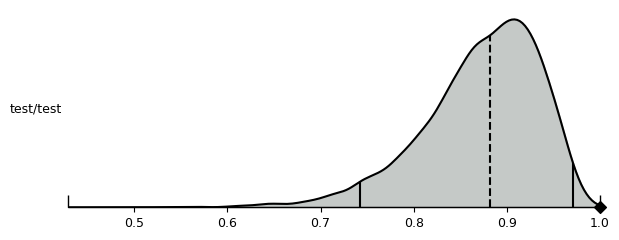

In [11]:
fig = study.plot_metric_summaries(metric="f1", class_label=0);


Admittedly, the default figure is a bit... bland. Luckily, the plots are highly configurable, making it easy to customize the look for your own down-stream reports/papers.

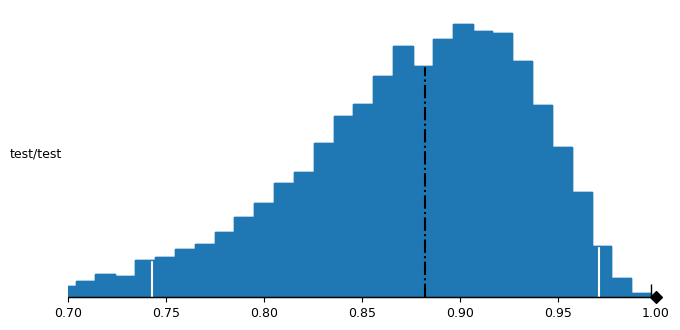

In [18]:
fig = study.plot_metric_summaries(
    metric="f1",
    class_label=0,
    method="histogram",
    bins=50,
    edge_colour="tab:blue",
    area_colour="tab:blue",
    area_alpha=1.0,
    hdi_lines_colour="white",
    median_line_format="-.",
    figsize=(6.9, 3.4),
    xlim=(0.7, 1.0),
);


## Next Steps

In the [next tutorial](https://ioverho.github.io/prob_conf_mat/Getting%20Started/02_comparing_experiments), we'll cover how to perform significance tests between experiments, and against baselines.

For more on configuring `Study` objects, metrics and confusion matrices:

* Check out the [`Study` documentation](https://ioverho.github.io/prob_conf_mat/Reference/Study) to get a sense of what a `Study` can do
* Check out the [how-to guide on `Study` configuration](https://ioverho.github.io/prob_conf_mat/How%20To%20Guides/configuration) to discover more advanced configuration settings
* Check out the [how-to guide on composing metrics & averaging methods](https://www.ioverho.github.io/prob_conf_mat/How%20To%20Guides/metric_syntax) to figure out which metrics you can use out of the box
* Check out the [how-to guide on priors](https://ioverho.github.io/prob_conf_mat/How%20To%20Guides/choosing_a_prior) to find out which prior hyperparameters can be used, and which are recommended
* See the [explainer on generating confusion matrices](https://www.ioverho.github.io/prob_conf_mat/Explanation/generating_confusion_matrices)